# Carga de paquetes

In [2]:
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import  DataLoader, ConcatDataset

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import os
import pylab as pl
from IPython import display
import nibabel
from preprocessing import * 

c:\Users\Aina\miniconda3\envs\tfg_aina\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] No se encontró el proceso especificado'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# CARGA DE DATOS

In [3]:
BASE_PATH = os.getcwd() + "\\data"
TRAINING_PATH_AMSTERDAM= BASE_PATH + "\\training\\Amsterdam\\GE3T\\"
TRAINING_PATH_SINGAPORE= BASE_PATH + "\\training\\Singapore\\"
TRAINING_PATH_UTRECHT= BASE_PATH + "\\training\\Utrecht\\"

TEST_PATH_AMSTERDAM= BASE_PATH + "\\test\\Amsterdam\\"
TEST_PATH_SINGAPORE= BASE_PATH + "\\test\\Singapore\\"
TEST_PATH_UTRECHT= BASE_PATH + "\\test\\Utrecht\\"

# DICCIONARIO TRAINING Y TEST

In [4]:
TRAINING_DICT={
    "pathsFLAIR":[],
    "pathsT1":[],
    "mask" :[],
    "location":[]
}
createDictionary(TRAINING_PATH_UTRECHT, TRAINING_DICT,"Utrecht")
createDictionary(TRAINING_PATH_SINGAPORE, TRAINING_DICT, "Singapore")
createDictionary(TRAINING_PATH_AMSTERDAM, TRAINING_DICT,"Amsterdam")

In [5]:
TEST_DICT={
    "pathsFLAIR":[],
    "pathsT1":[],
    "mask" :[],
    "location":[]
}
createDictionary(TEST_PATH_UTRECHT, TEST_DICT,"Utrecht")
createDictionary(TEST_PATH_SINGAPORE, TEST_DICT,"Singapore")
createDictionary(os.path.join(TEST_PATH_AMSTERDAM, "GE1T5"), TEST_DICT,"Amsterdam")
createDictionary(os.path.join(TEST_PATH_AMSTERDAM, "GE3T"), TEST_DICT,"Amsterdam")
createDictionary(os.path.join(TEST_PATH_AMSTERDAM, "Philips_VU .PETMR_01"), TEST_DICT,"Amsterdam")

# Crear dataset entrenamiento y test

In [6]:
train,val=divideDataset(TRAINING_DICT,0.8)
print("total training FLAIR images", len(train.__getitem__("pathsFLAIR")))
print("total test FLAIR images", len(val.__getitem__("pathsFLAIR")))

total training FLAIR images 48
total test FLAIR images 12


In [7]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128), antialias=True),
])

transform_label=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128), antialias=True, interpolation= transforms.InterpolationMode.NEAREST),
])

In [8]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,False)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,False)
test_dl = DataLoader(test_data, batch_size=15, shuffle=True)
print(train_dl.batch_size)

2829
751
30


# Preprocesamiento 

-   Cropping and padding
- obtiene region cerebral, se rellenan los huecos que pueda haber, se normaliza con gaussian normalization
- las imágenes finales tienen 2 canales ya que ponen una encima de la otra T1 Y FLAIR
- removing skull


(-0.5, 255.5, 255.5, -0.5)

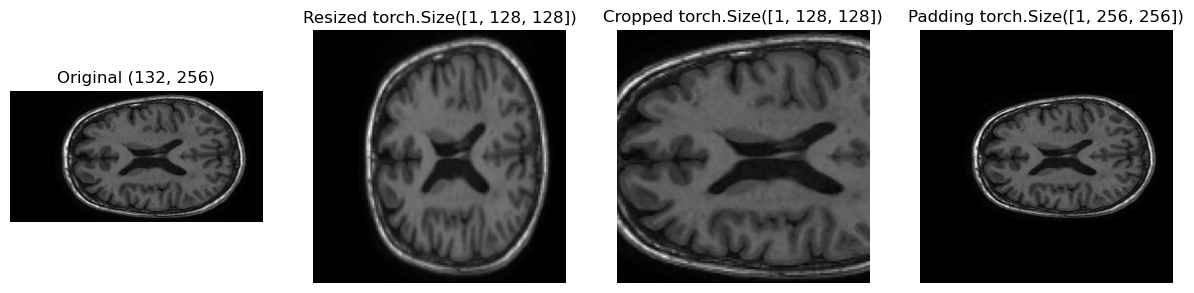

In [25]:
fig,axs = plt.subplots(1, 4, figsize=(15,5))
flair= os.path.join(TRAINING_PATH_AMSTERDAM, "100","pre","T1.nii.gz")
img = nibabel.load(flair)
image_data = img.get_fdata() 
image_orig=image_data[:, :,53]
axs[0].imshow(image_orig, cmap='gray')
axs[0].set_title("Original %s" %(image_orig.shape,))
axs[0].axis('off')

image_res=add_transformation(image_data[:, :, 53],128, True, False)
axs[1].imshow(image_res.squeeze(0), cmap='gray')
axs[1].set_title("Resized %s" %(image_res.shape,))
axs[1].axis('off')

image_crop=add_transformation(image_data[:, :, 53],128, False,False)
axs[2].imshow(image_crop.squeeze(0), cmap='gray')
axs[2].set_title("Cropped %s" %(image_crop.shape,))
axs[2].axis('off')

image_pad=add_transformation(image_data[:, :, 53],256, False,False)
axs[3].imshow(image_pad.squeeze(0), cmap='gray')
axs[3].set_title("Padding %s" %(image_pad.shape,))
axs[3].axis('off')


# Skull stripping

# Concatenar imágenes

(-0.5, 255.5, 131.5, -0.5)

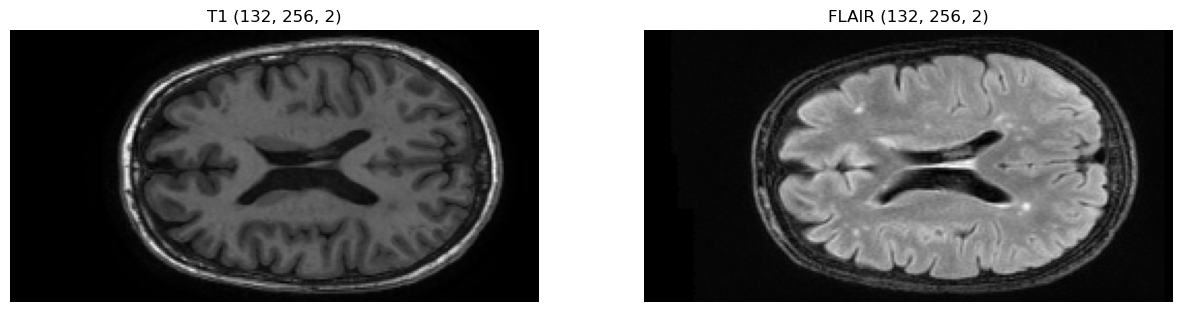

In [30]:
fig,axs = plt.subplots(1, 2, figsize=(15,5))
flair= os.path.join(TRAINING_PATH_AMSTERDAM, "100","pre","FLAIR.nii.gz")
t1=os.path.join(TRAINING_PATH_AMSTERDAM, "100","pre","T1.nii.gz")

fl = nibabel.load(flair)
fl_data = fl.get_fdata()[:,:,53] 
t=nibabel.load(t1)
t_data=t.get_fdata()[:,:,53] 
image_orig=numpy.concatenate((t_data[...,np.newaxis],fl_data[...,np.newaxis]), axis=2)
axs[0].imshow(image_orig[...,0], cmap='gray')
axs[0].set_title("T1 %s" %(image_orig.shape,))
axs[0].axis('off')

axs[1].imshow(image_orig[...,1], cmap='gray')
axs[1].set_title("FLAIR %s" %(image_orig.shape,))
axs[1].axis('off')

## Brain Filling &  Normalización

(-0.5, 255.5, 131.5, -0.5)

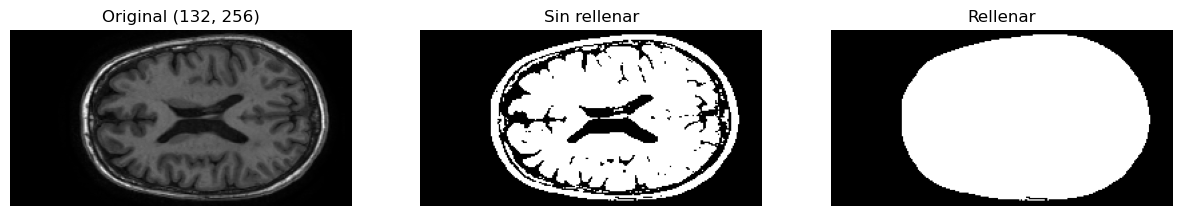

In [ ]:
fig,axs = plt.subplots(1, 3, figsize=(15,5))
flair= os.path.join(TRAINING_PATH_AMSTERDAM, "100","pre","T1.nii.gz")
img = nibabel.load(flair)
image_data = img.get_fdata() 
image_orig=image_data[:, :,53]
axs[0].imshow(image_orig, cmap='gray')
axs[0].set_title("Original %s" %(image_orig.shape,))
axs[0].axis('off')

mask= brainMask(image_orig)
axs[1].imshow(mask, cmap='gray')
axs[1].set_title("Sin rellenar")
axs[1].axis('off')


mask= brainfilling(mask)
axs[2].imshow(mask, cmap='gray')
axs[2].set_title("Rellenar")
axs[2].axis('off')


(-0.5, 255.5, 131.5, -0.5)

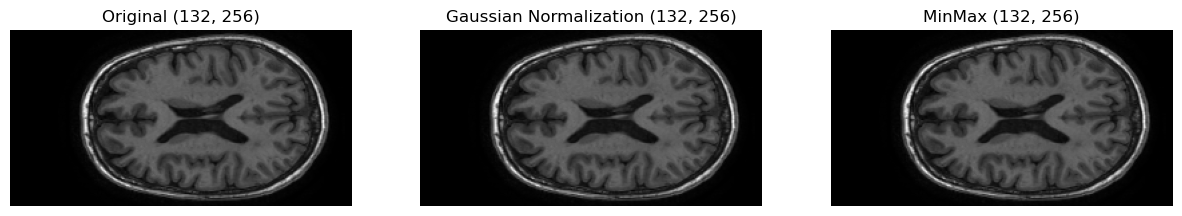

In [ ]:

fig,axs = plt.subplots(1, 3, figsize=(15,5))
flair= os.path.join(TRAINING_PATH_AMSTERDAM, "100","pre","T1.nii.gz")
img = nibabel.load(flair)
image_data = img.get_fdata() 
image_orig=image_data[:, :,53]
axs[0].imshow(image_orig, cmap='gray')
axs[0].set_title("Original %s" %(image_orig.shape,))
axs[0].axis('off')

image_res=gaussian_normalizationFILL(image_data[:, :, 53], mask)
axs[1].imshow(image_res, cmap='gray')
axs[1].set_title("Gaussian Normalization %s" %(image_res.shape,))
axs[1].axis('off')

image_crop=minmax_normalizationFILL(image_data[:, :, 53], mask)
axs[2].imshow(image_crop, cmap='gray')
axs[2].set_title("MinMax %s" %(image_crop.shape,))
axs[2].axis('off')

# MÉTODOS ENTRENAMIENTO

In [ ]:
from unet import UNet 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=1,out_channels=1, init_features=32)

In [ ]:
def traintestpipeline(epochs: int, optim: Adam, criterion: DiceLoss, min_loss: int, name: str):
    t_loss = np.zeros((epochs))
    v_loss = np.zeros((epochs))
    pbar = tqdm(range(1, epochs+1)) # tdqm permet tenir text dinàmic
    for epoch in pbar:
        
        train_loss = 0 
        val_loss = 0  
        
        model.train()                                                  
        for batch_num, (input_img, target) in enumerate(train_dl, 1):   
        

            input_img= input_img.to(device).float()
            target = target.to(device)
            
            
            output = model(input_img)
            loss = criterion(output, target)
            loss.backward()                                            
            optim.step()                                               
            optim.zero_grad()     
            
            train_loss += loss.item()    
                                                        
        model.eval()   
        with torch.no_grad():                                          
            for input_img, target in val_dl: 
                input_img = input_img.to(device).float()
                target = target.to(device)
                
                output = model(input_img)                                   
                loss = criterion(output, target)   
                val_loss += loss.item()  
        
        # RESULTATS
        train_loss /= len(train_dl)
        t_loss[epoch-1] = train_loss
        
        val_loss /= len(val_dl)   
        v_loss[epoch-1] = val_loss
        if(v_loss[epoch-1]<min_loss):
            min_loss=v_loss[epoch-1]
            torch.save(model.state_dict(), name)  
        # VISUALITZACIO DINAMICA
        plt.figure(figsize=(12, 4))
        pl.plot(t_loss[:epoch], label="train")
        pl.plot(v_loss[:epoch], label="validation")
        pl.legend()
        pl.xlim(0, epochs)
        pl.xticks(range(0,epochs,1),range(1,epochs+1,1))
        
        display.clear_output(wait=True)
        display.display(pl.gcf())
        plt.close()

        pbar.set_description(f"Epoch:{epoch} Training Loss:{train_loss} Validation Loss:{val_loss}")

## Modelo con todo el conjunto de imágenes

In [ ]:
transform, transform_label=transform_setter(128,True)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,False)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,False)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

2899
681


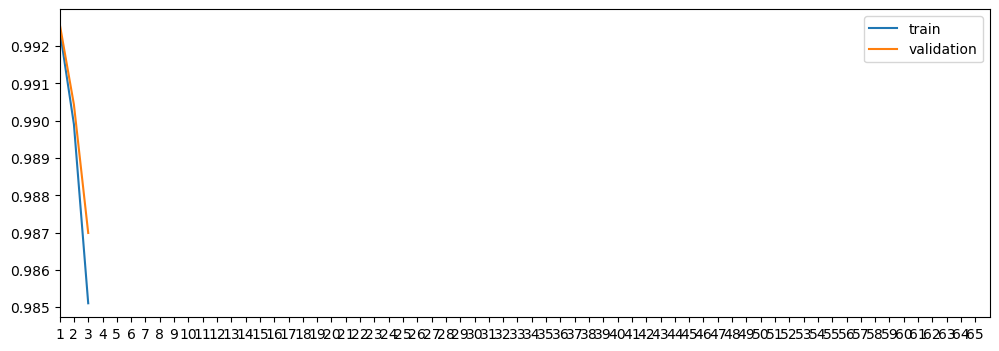

Epoch:3 Training Loss:0.9851064750722838 Validation Loss:0.9869904313195185:   5%|▍         | 3/65 [14:29<4:59:36, 289.95s/it]


KeyboardInterrupt: 

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/NODeletion128FLAIR.pt")

In [ ]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,False)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,False)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/NODeletion128T1.pt")

# Modelo sin el 20% de los slices:

In [ ]:
transform, transform_label=transform_setter(128,True)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/Deletion128FLAIR.pt")

In [ ]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/Deletion128T1.pt")

# Modelos con Resize 

Se asume que sin los slices el modelo es mejor(Pendiente de los resultados)

## 128x128 

In [ ]:
transform, transform_label=transform_setter(128,True)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize128FLAIR.pt")

In [ ]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize128T1.pt")

## 256 x 256

In [ ]:
transform, transform_label=transform_setter(256,True)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize256FLAIR.pt")

In [ ]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label, False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize256T1.pt")

## 384 x 384

In [ ]:
transform, transform_label=transform_setter(384,True)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label, False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize384FLAIR.pt")

In [ ]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label, False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize384T1.pt")

## 200 x 200

In [ ]:
transform, transform_label=transform_setter(200,True)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label, False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize200FLAIR.pt")

In [ ]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/RESIZE/Resize200T1.pt")

# Modelos con Crop/Pad

## 200 x 200

In [ ]:
transform, transform_label=transform_setter(200,False)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label, False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop200FLAIR.pt")

In [ ]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label, False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop200T1.pt")

## 240 x240

In [ ]:
transform, transform_label=transform_setter(240,False)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label, False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop240FLAIR.pt")

In [ ]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop240T1.pt")

## 256 x 256

In [ ]:
transform, transform_label=transform_setter(256,False)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label, False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop256FLAIR.pt")

In [ ]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop256T1.pt")

## 384 x 384

In [ ]:
transform, transform_label=transform_setter(384,False)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label, False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop384FLAIR.pt")

In [ ]:
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/CROP/Crop384T1.pt")

# Modelos con Normalizacion

Se asume un tamaño con Reize de 256x256(pendiente resultados)
Se asume un tamaño con Crop and Pad de 200x200(pendiente resultados)

## Gaussian Normalization Resize 256x256

- 1: Gaussian normalization
- 3: Gaussian Normalization cerebro
- 5: gaussian normalization del cerebro completo

In [ ]:
transform, transform_label=transform_normalization(256,True,1)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE/GN256FLAIR.pt")

In [ ]:
transform, transform_label=transform_normalization(256,True,1)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE/GN256T1.pt")

In [ ]:
transform, transform_label=transform_normalization(256,True,3)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE//GNMask256FLAIR.pt")

In [ ]:
transform, transform_label=transform_normalization(256,True,3)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE//GNMask256T1.pt")

In [ ]:
transform, transform_label=transform_normalization(256,True,5)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE//GNFill256FLAIR.pt")

In [ ]:
transform, transform_label=transform_normalization(256,True,5)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_RESIZE/GNMask256T1.pt")

## MINMAX NORMALIZATION RESIZE 256X256

- 2: min max normalization
- 4: min max del cerebro
- 6: minmax del cerebro entero

In [ ]:
transform, transform_label=transform_normalization(256,True,2)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_RESIZE/MM200FLAIR.pt")

In [ ]:
transform, transform_label=transform_normalization(256,True,2)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_RESIZE/MM200T1.pt")

In [ ]:
transform, transform_label=transform_normalization(256,True,4)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_RESIZE/MMmask200FLAIR.pt")

In [ ]:
transform, transform_label=transform_normalization(256,True,4)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_RESIZE/MMmask200T1.pt")

In [ ]:
transform, transform_label=transform_normalization(256,True,6)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_RESIZE/MMFill200FLAIR.pt")

In [ ]:
transform, transform_label=transform_normalization(256,True,6)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_RESIZE/MMFill200T1.pt")

## Gaussian Normalization CropandPad 200x200

In [ ]:
transform, transform_label=transform_normalization(200,False,1)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_CROP/GN200FLAIR.pt")

In [ ]:
transform, transform_label=transform_normalization(200,False,1)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_CROP/GN200T1.pt")

In [ ]:
transform, transform_label=transform_normalization(200,False,3)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_CROP/GNMask200FLAIR.pt")

In [ ]:
transform, transform_label=transform_normalization(200,False,3)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_CROP/GNMask200T1.pt")

In [ ]:
transform, transform_label=transform_normalization(200,False,5)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_CROP/GNFill200FLAIR.pt")

In [ ]:
transform, transform_label=transform_normalization(200,False,5)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/GN_CROP/GNFill200T1.pt")

## Min max Normalization 200x200 crop and pad

In [ ]:
transform, transform_label=transform_normalization(200,False,2)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_CROP/MM200Flair.pt")

In [ ]:
transform, transform_label=transform_normalization(200,False,2)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_CROP/MM200T1.pt")

In [ ]:
transform, transform_label=transform_normalization(200,False,4)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_CROP/MMmask200Flair.pt")

In [ ]:
transform, transform_label=transform_normalization(200,False,4)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_CROP/MMmask200T1.pt")

In [ ]:
transform, transform_label=transform_normalization(200,False,6)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsFLAIR",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsFLAIR"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_CROP/MMFill200FLAIR.pt")

In [ ]:
transform, transform_label=transform_normalization(200,False,6)
train_data,val_data,train_dl,val_dl = dataLoaders("pathsT1",train,val,transform, transform_label,False,30,True)
test_data=Slices(TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label,True)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

In [ ]:
epochs = 65
optim = Adam(model.parameters(), lr=1e-3)
criterion = DiceLoss() 
min_loss=1000
traintestpipeline(epochs, optim, criterion, min_loss,"./Modelos3DUNET/MM_CROP/MMFill200T1.pt")

# Modelos con skull striping

# Modelos Con Concatenate

Se ha seleccionado inicialmente crop de 200 y normalizacion fill brain gaussian

In [1]:
transform, transform_label=transform_normalization(200,False,5)
train_data,val_data,train_dl,val_dl = dataLoadersConcatenate("pathsFLAIR","pathsT1",train,val,transform, transform_label,False,30)
test_data=Concatenate(TEST_DICT.get("pathsFLAIR"),TEST_DICT.get("pathsT1"), TEST_DICT.get("mask"), transform, transform_label)
test_dl = DataLoader(test_data, batch_size=15, shuffle=False)

NameError: name 'transform_normalization' is not defined

# Data Augmentation

- Rotation (-15,15)
- Scale (0.9,1.1)
- Shearing(-18,18)


In [ ]:
fig,axs = plt.subplots(1, 4, figsize=(15,5))
flair= os.path.join(TRAINING_PATH_AMSTERDAM, "100","pre","T1.nii.gz")
img = nibabel.load(flair)
image_data = img.get_fdata() 
image_orig=image_data[:, :,53]
axs[0].imshow(image_orig, cmap='gray')
axs[0].set_title("Original %s" %(image_orig.shape,))
axs[0].axis('off')

image_rot=dataAugmentation(image_data[:, :, 53],(-15,15),None,None)
axs[1].imshow(image_rot.squeeze(0), cmap='gray')
axs[1].set_title("Rotation %s" %(image_rot.shape,))
axs[1].axis('off')

image_scale=dataAugmentation(image_data[:, :, 53],(0,0),(0.9,1.1),None)
axs[2].imshow(image_scale.squeeze(0), cmap='gray')
axs[2].set_title("scale %s" %(image_scale.shape,))
axs[2].axis('off')

image_she=dataAugmentation(image_data[:, :, 53],(0,0),None,(-18,18))
axs[3].imshow(image_she.squeeze(0), cmap='gray')
axs[3].set_title("shear %s" %(image_she.shape,))
axs[3].axis('off')